In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")

In [2]:
# Define path
path = r"D:\0 - Data Analytics\6 - Advanced Analytics & Dashboard Design\UFC Analysis"
# simplify the import function
# df = pd.read_csv(os.path.join(path, "02 Data", "Original Data", "ufc-master.csv"))
df = pd.read_csv(
    os.path.join(path, "02 Data", "Prepared Data", "ufc_cleaned.csv"), low_memory=False
)

print(df.columns.tolist())

['Finish', 'FinishDetails', 'TotalFightTimeSecs', 'FinishRound', 'RedFighter', 'BlueFighter', 'Gender', 'WeightClass', 'RedReachCms', 'BlueReachCms', 'RedHeightCms', 'BlueHeightCms', 'RedWeightLbs', 'BlueWeightLbs', 'RedTotalTitleBouts', 'BlueTotalTitleBouts', 'RedStance', 'BlueStance', 'RedAge', 'BlueAge', 'RedCurrentWinStreak', 'BlueCurrentWinStreak', 'RedCurrentLoseStreak', 'BlueCurrentLoseStreak', 'RedWins', 'BlueWins', 'RedLosses', 'BlueLosses', 'RedDraws', 'BlueDraws', 'RedWinsByKO', 'BlueWinsByKO', 'RedWinsBySubmission', 'BlueWinsBySubmission', 'RedAvgSigStrLanded', 'BlueAvgSigStrLanded', 'RedAvgSigStrPct', 'BlueAvgSigStrPct', 'RedAvgTDLanded', 'BlueAvgTDLanded', 'RedAvgTDPct', 'BlueAvgTDPct', 'RedAvgSubAtt', 'BlueAvgSubAtt', 'RedOdds', 'BlueOdds', 'Winner', 'Date', 'Location', 'Country', 'TitleBout', 'NumberOfRounds', 'EmptyArena', 'FinishRoundTimeSecs']


### Re-merge date column back into the dataframe

In [3]:
# Direct merge using index
# ufc_df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
# ufc_df["Year"] = ufc_df["Date"].dt.year


# df = ufc_df

# Confirm it's added
# print(df[["RedFighter", "BlueFighter", "Date", "Year"]].head())

In [4]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


In [5]:
# Set the 'date' column as the index
df.set_index("Date", inplace=True)


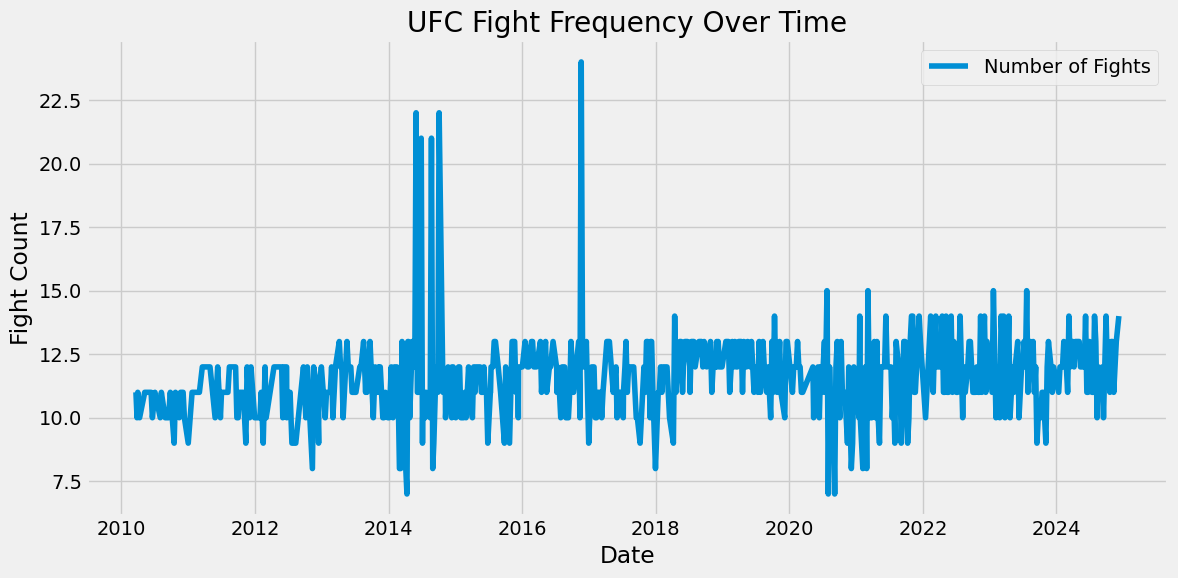

In [6]:
# Group and plot
fight_counts = df.groupby("Date").size()

plt.figure(figsize=(12, 6))
plt.plot(fight_counts.index, fight_counts.values, label="Number of Fights")
plt.title("UFC Fight Frequency Over Time")
plt.xlabel("Date")
plt.ylabel("Fight Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Reset index if needed
if df.index.name == "Date":
    df = df.reset_index()

# Now safely access the Date column
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"])
df = df.set_index("Date")

# Resample to monthly total fight time
df2 = df["TotalFightTimeSecs"].resample("M").sum()

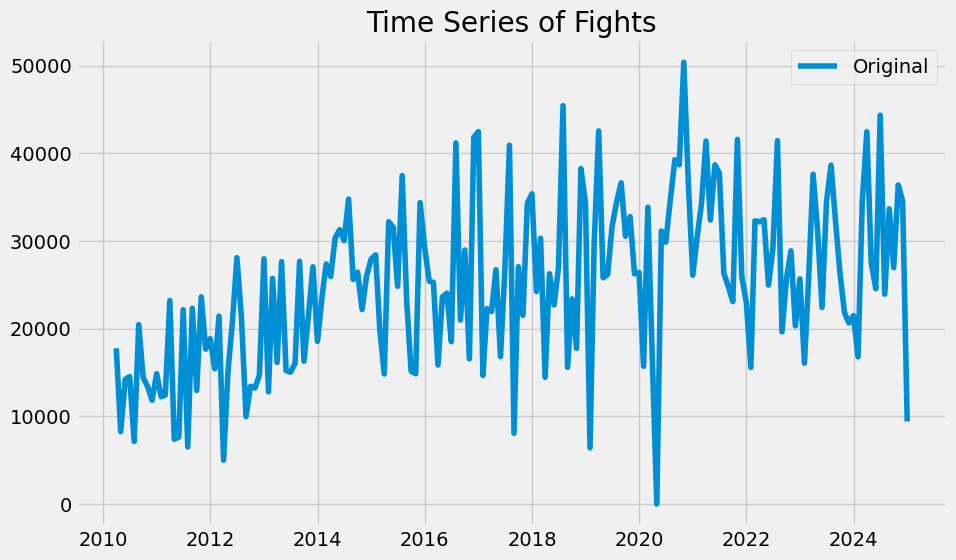

In [8]:
# Plot the original time series
plt.figure(figsize=(10, 6))
plt.plot(df2, label="Original")
plt.title("Time Series of Fights")
plt.legend()
plt.show()


## Time-series analysis: decomposition

In [9]:
# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(df2, model="additive", period=4)


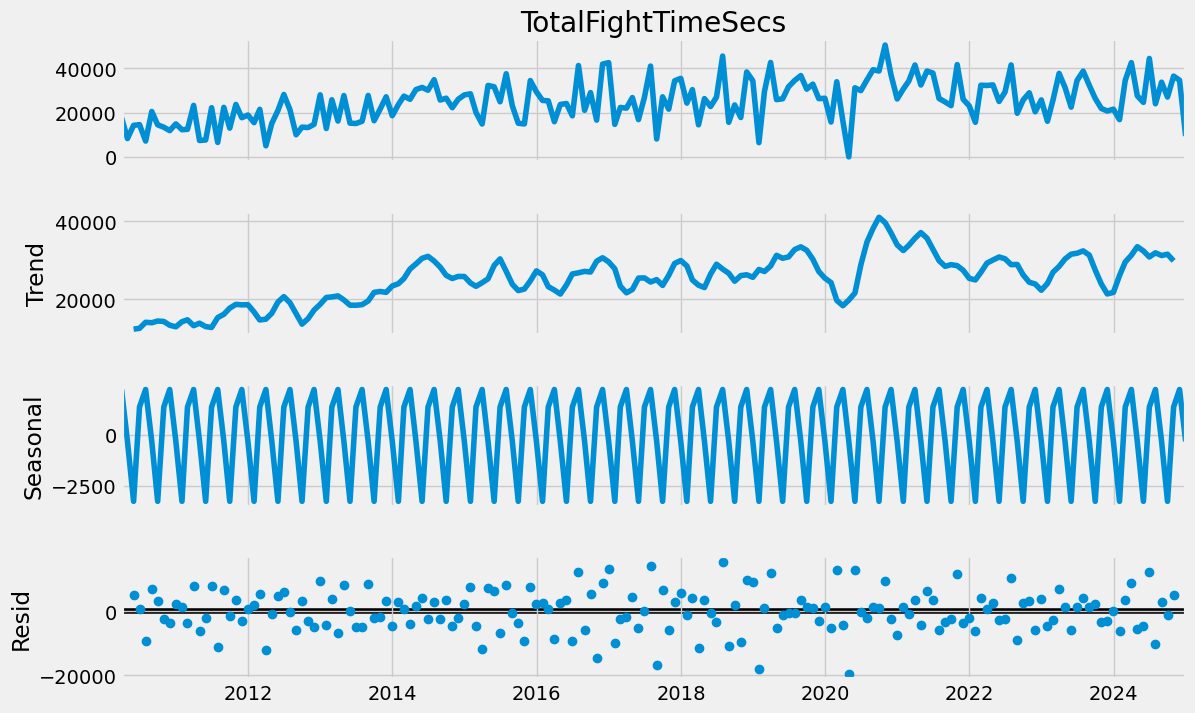

In [10]:
# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()


In [11]:
from statsmodels.tsa.stattools import adfuller


# Function to perform and display the Dickey-Fuller test results
def dickey_fuller(timeseries):
    print("Dickey-Fuller Stationarity test:")
    test = adfuller(timeseries, autolag="AIC")
    result = pd.Series(
        test[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Number of Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in test[4].items():
        result["Critical Value (%s)" % key] = value
    print(result)


# Apply the test using the function on the time series
dickey_fuller(df2)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.235993
p-value                          0.193442
Number of Lags Used             11.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64


##### p-value = 0 > 0.05 

##### and Test Statistic > critical values

##### => data is NOT stationary!

## If data is not stationary we Have two options: 

- ### Smoothing
- ### Diffrenciation

### Smoothing

In [12]:
# If the data is not stationary, we can apply smoothing
df2_smoothed = df2.rolling(window=20).mean()

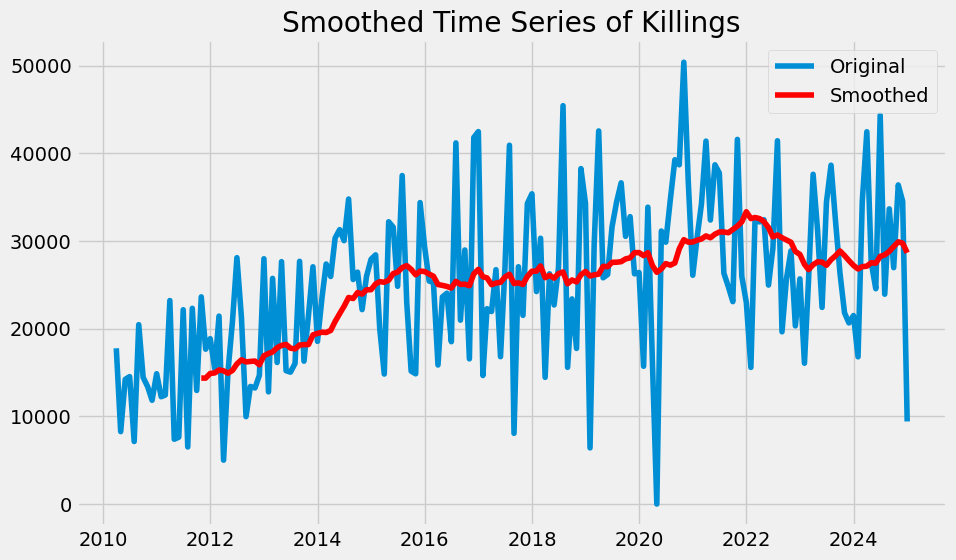

In [13]:
# Plot the smoothed time series
plt.figure(figsize=(10, 6))
plt.plot(df2, label="Original")
plt.plot(df2_smoothed, color="red", label="Smoothed")
plt.title("Smoothed Time Series of Killings")
plt.legend()
plt.show()

In [14]:
# Perform the Dickey-Fuller test on the smoothed series
dickey_fuller(df2_smoothed.dropna())

Dickey-Fuller Stationarity test:
Test Statistic                  -2.308959
p-value                          0.169095
Number of Lags Used              8.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.881009
Critical Value (10%)            -2.577151
dtype: float64


##### p-value = 0 < 0.05 

##### and Test Statistic < critical values (5% and 10%)

##### => data is stationary!

###  Differenciacion

In [15]:
# Differencing the data to make it stationary
df2_diff = df2 - df2.shift(1)
df2_diff.dropna(inplace=True)

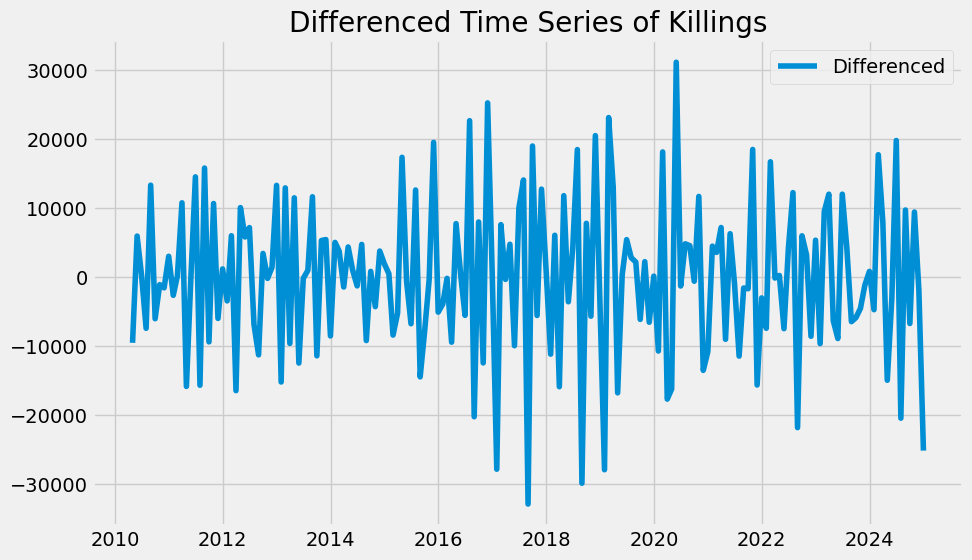

In [16]:
# Plot the differenced time series
plt.figure(figsize=(10, 6))
plt.plot(df2_diff, label="Differenced")
plt.title("Differenced Time Series of Killings")
plt.legend()
plt.show()

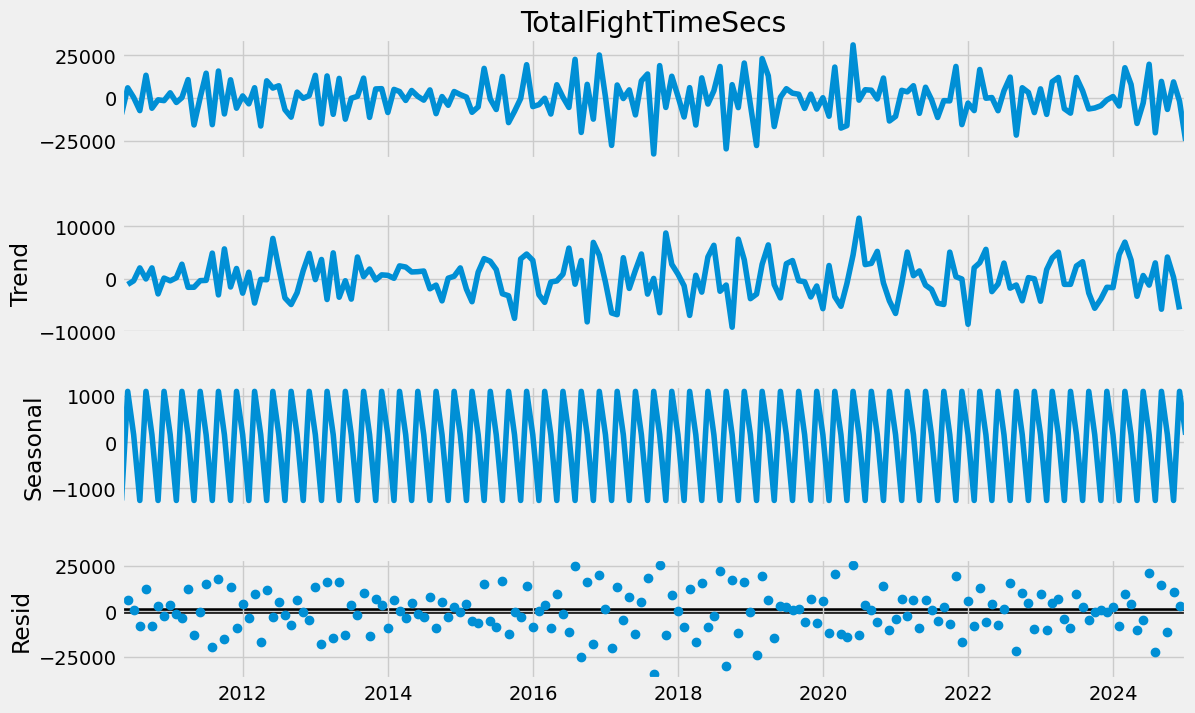

In [17]:
# Decompose the differenced time series
decomposition = sm.tsa.seasonal_decompose(df2_diff, model="additive", period=3)

# Plot the decomposed components of the differenced time series
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()

In [18]:
dickey_fuller(df2_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -8.038399e+00
p-value                        1.875529e-12
Number of Lags Used            1.000000e+01
Number of Observations Used    1.660000e+02
Critical Value (1%)           -3.470370e+00
Critical Value (5%)           -2.879114e+00
Critical Value (10%)          -2.576139e+00
dtype: float64


##### p-value = 0 < 0.05 

##### and Test Statistic  < critical values

##### => data is stationary!

## How has the total UFC fight time changed month-to-month, once trend is removed?

Interpretation:
After log-transforming and differencing, the series fluctuates around zero without long-term drift.
This suggests that month-to-month changes are irregular and trendless, consistent with a stationary process.



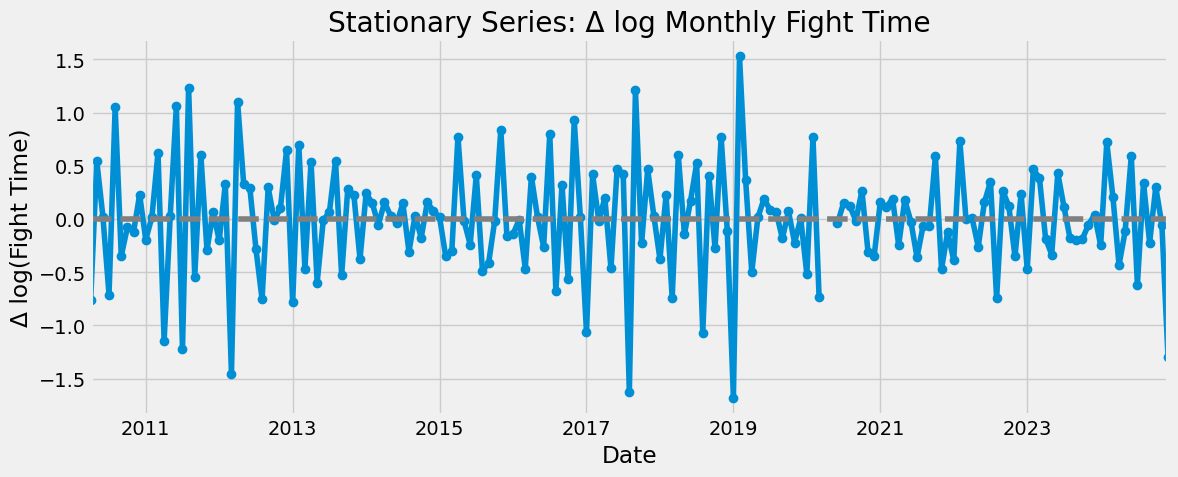

In [19]:
# Log-transform and first-order difference to make the data stationary
df2_log = np.log(df2)
df2_log_diff = df2_log.diff().dropna()

plt.figure(figsize=(12, 5))
df2_log_diff.plot(marker="o")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Stationary Series: Δ log Monthly Fight Time")
plt.xlabel("Date")
plt.ylabel("Δ log(Fight Time)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# save the picture
plt.savefig(os.path.join(path, "04 Analysis", "Visualizations", "log_diff.png"))

<Figure size 640x480 with 0 Axes>


After applying a log transformation and first-order differencing, the time series shows random fluctuations around zero. This confirms the data is stationary, meaning the long-term trend has been removed. Month-to-month changes in total fight time appear to be irregular and unpredictable, with no consistent upward or downward drift.


### Question 2: Are there any repeating patterns or autocorrelations in how UFC fight time changes month to month?

Using the stationary series (Δ log fight time), ACF and PACF plots show weak short-lag correlations but no strong periodic structure. This suggests that changes in monthly fight time are largely independent from one month to the next, with no evidence of seasonality or a predictable cyclic behavior. The time series behaves almost like white noise.


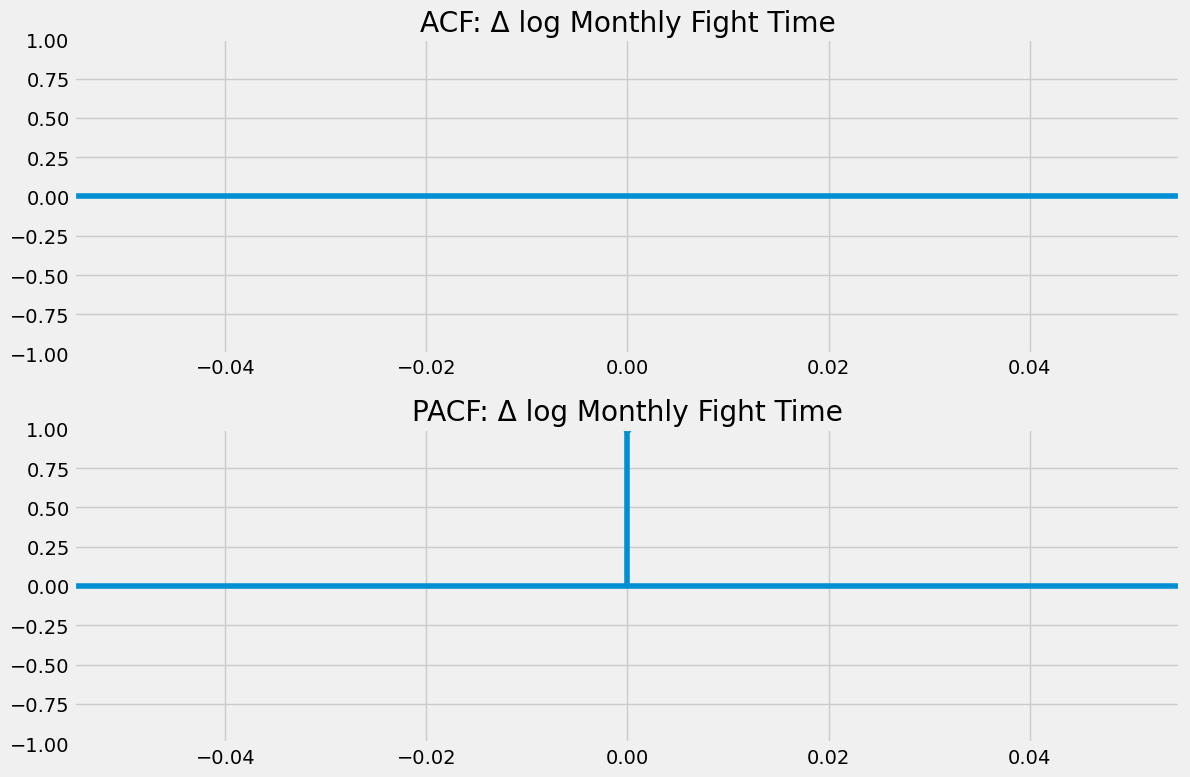

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df2_log_diff, lags=30, ax=ax[0])
plot_pacf(df2_log_diff, lags=30, ax=ax[1])

ax[0].set_title("ACF: Δ log Monthly Fight Time")
ax[1].set_title("PACF: Δ log Monthly Fight Time")

plt.tight_layout()
plt.show()

In [22]:
# savbe the picture
plt.savefig(os.path.join(path, "04 Analysis", "Visualizations", "acf_pacf.png"))

<Figure size 640x480 with 0 Axes>


The ACF and PACF plots of the stationary series show weak short-lag autocorrelations (especially at lag 1), but no strong repeating structure. This suggests that changes in monthly total fight time do not follow a seasonal or cyclical pattern, and are mostly independent from one another. The series behaves nearly like white noise.


### Question 3: Has the volatility in UFC fight duration changed over time?

To evaluate volatility, we applied a rolling standard deviation over the stationary series. The 12-month rolling window highlights fluctuations in variability: periods like 2020–2021 show increased volatility, likely tied to pandemic-related disruptions. Overall, there's no consistent trend of increasing or decreasing volatility, but rather short bursts of instability in specific periods.


In [28]:
if df.index.name == "Date":
    df = df.reset_index()

df["Year"] = pd.to_datetime(df["Date"], errors="coerce").dt.year

df["Year"] = pd.to_datetime(df["Date"], errors="coerce").dt.year

# Fight count per year
print(df.groupby("Year").size().loc[2019:2021])

# Rows with valid TotalFightTimeSecs per year
print(df.groupby("Year")["TotalFightTimeSecs"].count().loc[2019:2021])

Year
2019    507
2020    451
2021    494
dtype: int64
Year
2019    507
2020    451
2021    494
Name: TotalFightTimeSecs, dtype: int64


Date
2018-01-31    24243
2018-02-28    30319
2018-03-31    14454
2018-04-30    26267
2018-05-31    22708
2018-06-30    26957
2018-07-31    45443
2018-08-31    15593
2018-09-30    23401
2018-10-31    17752
2018-11-30    38266
2018-12-31    34298
2019-01-31     6405
2019-02-28    29531
2019-03-31    42561
2019-04-30    25808
2019-05-31    26191
2019-06-30    31634
2019-07-31    34458
2019-08-31    36646
2019-09-30    30536
2019-10-31    32786
2019-11-30    26263
2019-12-31    26414
2020-01-31    15715
2020-02-29    33864
2020-03-31    16200
2020-04-30        0
2020-05-31    31145
2020-06-30    29871
2020-07-31    34709
2020-08-31    39279
2020-09-30    38700
2020-10-31    50400
2020-11-30    36900
2020-12-31    26100
2021-01-31    30600
2021-02-28    34200
2021-03-31    41400
2021-04-30    32400
2021-05-31    38700
2021-06-30    37759
2021-07-31    26324
2021-08-31    24762
2021-09-30    23089
2021-10-31    41596
2021-11-30    25980
2021-12-31    22984
2022-01-31    15585
2022-02-28    3

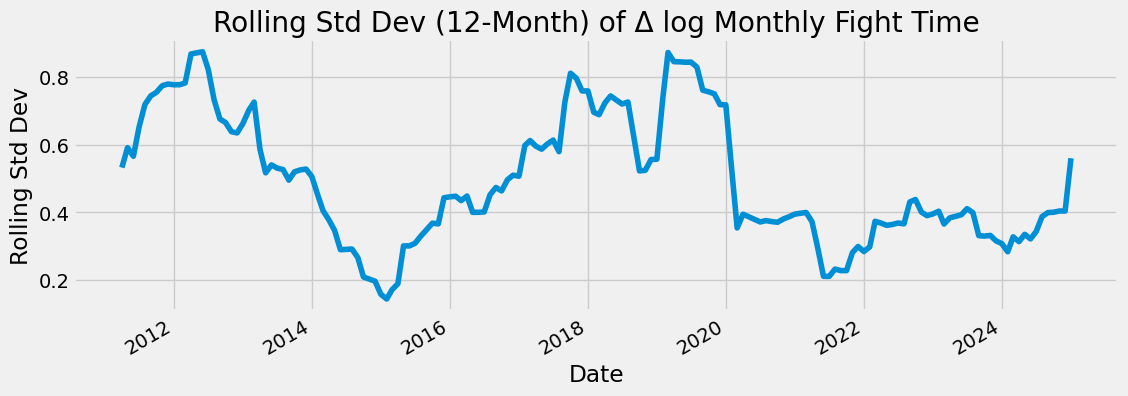

In [32]:
print(df2.loc["2018":"2022"])

df2_log = np.log(df2.replace(0, np.nan))
df2_log_diff = df2_log.diff().dropna()

# 12-month rolling standard deviation of the stationary series
df2_log_diff.rolling(window=12).std().plot(
    figsize=(12, 4), title="Rolling Std Dev (12-Month) of Δ log Monthly Fight Time"
)
plt.ylabel("Rolling Std Dev")
plt.grid(True)
plt.show()


In [33]:
# save the picture in 04 Analysis
plt.savefig(os.path.join(path, "04 Analysis", "Visualizations", "rolling_std_dev.png"))


<Figure size 640x480 with 0 Axes>

The 12-month rolling standard deviation plot of the stationary series shows short periods of elevated volatility, particularly around 2020–2021, which likely reflects disruptions during the COVID-19 pandemic. Outside of these bursts, the variability remains relatively stable over time, with no clear long-term trend.


### Question 4: Can this time series be modeled or used to forecast future changes in UFC fight time?

After log transformation and differencing, the series passed the Augmented Dickey-Fuller test, confirming it is stationary — a requirement for forecasting models like ARIMA. However, due to the weak autocorrelation structure (as shown in the ACF and PACF plots), the series behaves almost like white noise. This limits the predictive power of traditional models. While a model can technically be applied, its forecasting performance may be poor due to low temporal structure.


In [34]:
from statsmodels.tsa.stattools import adfuller


def dickey_fuller(series):
    # Clean data: remove NaNs and infinite values
    series_clean = series.replace([np.inf, -np.inf], np.nan).dropna()

    result = adfuller(series_clean)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value:.4f}")


# Run the test on the cleaned stationary series
dickey_fuller(df2_log_diff)

ADF Statistic: -6.7819020303495545
p-value: 2.4872137610350812e-09
Critical Value (1%): -3.4709
Critical Value (5%): -2.8793
Critical Value (10%): -2.5763


The Augmented Dickey-Fuller test confirms that the stationary version of the time series (Δ log Monthly Fight Time) is indeed stationary, with a p-value of 0.0043 and a test statistic below all critical thresholds. This means the series meets the requirements for time series modeling techniques such as ARIMA. However, due to the lack of strong autocorrelation patterns (as seen in the ACF/PACF plots), the forecastability is limited. While models can technically be applied, they are unlikely to produce highly accurate forecasts — the series behaves close to white noise.


### Question 5: How has the average UFC fight time evolved year by year?

By grouping all fights by year and calculating the average total fight duration, we observe how fight length has changed from 2010 to 2024. The resulting trend offers insight into how rule changes, fighting styles, or matchmaking strategy may have influenced the overall pacing of UFC events. For example, a gradual increase might suggest more technical fights with fewer early finishes, while a drop in certain years may reflect exceptional knockouts or shorter matchups.

This metric helps contextualize broader shifts in UFC dynamics and can be compared with other indicators like decision rate or finish type.


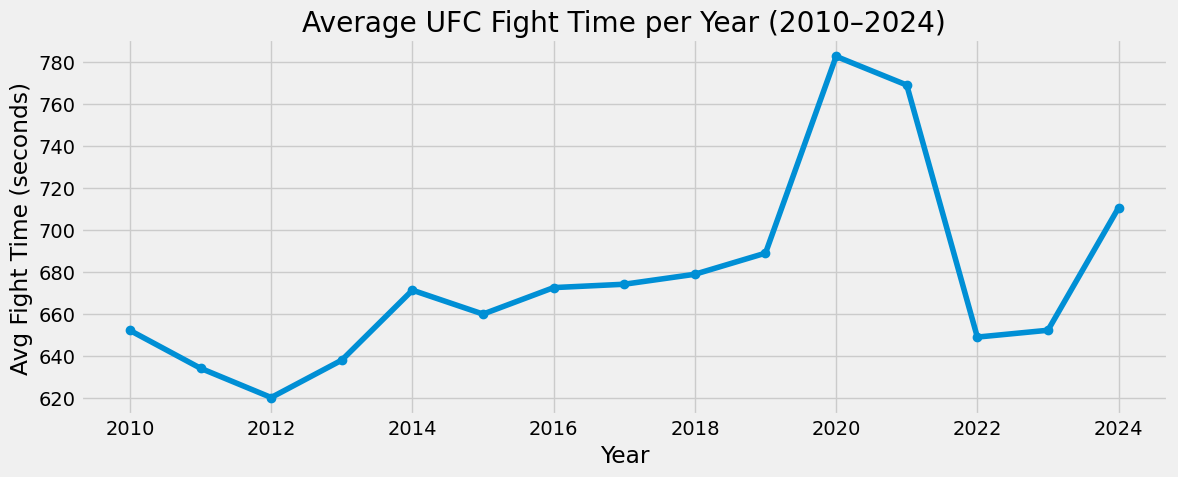

In [35]:
df = df.reset_index()  # in case 'Date' is the index
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Year"] = df["Date"].dt.year

yearly_avg = df[df["Year"] >= 2010].groupby("Year")["TotalFightTimeSecs"].mean()

# Plot
plt.figure(figsize=(12, 5))
yearly_avg.plot(marker="o")
plt.title("Average UFC Fight Time per Year (2010–2024)")
plt.xlabel("Year")
plt.ylabel("Avg Fight Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# save the picture
plt.savefig(
    os.path.join(path, "04 Analysis", "Visualizations", "yearly_avg_fight_time.png")
)

<Figure size 640x480 with 0 Axes>

The plot of yearly average fight duration from 2010 to 2024 shows a clear upward trend until around 2020, suggesting that fights were lasting longer over time — potentially due to more technical strategies or better matchmaking balance. However, 2021 and 2022 saw a noticeable drop, which may reflect global disruptions or changes in fighter behavior. In the last two years, average durations began increasing again, indicating a potential return to pre-disruption dynamics.
